In [1]:
%matplotlib inline


Conservation of *LexA* DNA-binding site
=======================================

The web page on sequence logos on
`Wikipedia <https://en.wikipedia.org/wiki/Sequence_logo#Consensus_logo>`_
shows the sequence logo of the *LexA*-binding motif of Gram-positive
bacteria. In this example we look at the other side: What is the
amino acid sequence logo of the DNA-binding site of the LexA repressor?

We start by searching the NCBI Entrez database for *lexA* gene
entries in the UniProtKB database and downloading them afterwards as
GenPept file.
In order to ensure that the file contains the desired entries, we check
the entires for their definition (title) and source (species).


In [1]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import biotite.sequence as seq
import biotite.sequence.io.fasta as fasta
import biotite.sequence.io.genbank as gb
import biotite.sequence.graphics as graphics
import biotite.application.muscle as muscle
import biotite.database.entrez as entrez
# Search for protein products of LexA gene in UniProtKB/Swiss-Prot database
query =   entrez.SimpleQuery("lexA", "Gene Name") \
        & entrez.SimpleQuery("srcdb_swiss-prot", "Properties")
# Search for the first 200 hits
# More than 200 UIDs are not recommended for the EFetch service
# for a single fetch
uids = entrez.search(query, db_name="protein", number=200)
file = entrez.fetch_single_file(
    uids, None, db_name="protein", ret_type="gp"
)
# The file contains multiple concatenated GenPept files
# -> Usage of MultiFile
multi_file = gb.MultiFile.read(file)
# Separate MultiFile into single GenBankFile instances
files = [f for f in multi_file]
print("Definitions:")
for file in files[:20]:
    print(gb.get_definition(file))
print()
print("Sources:")
for file in files[:20]:
    print(gb.get_source(file))

Definitions:
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.
RecName: Full=LexA repressor.

Sources:
Listeria welshimeri serovar 6b str. SLCC5334
Leptospira interrogans serovar Copenhageni str. Fiocruz L1-130
Salmonella enterica subsp. enterica serovar Typhimurium str. LT2
Brucella melitensis bv. 1 str. 16M
Fibrobacter succinogenes subsp. succinogenes S85
Mycobacterium avium subsp. paratuberculosis K-10
Pectobacterium carotovorum subsp. carotovorum PC1
Listeria monocytogene

The names of the sources are too long to be properly displayed later
on. Therefore, we write a function that creates a proper abbreviation
for a species name.



In [2]:
def abbreviate(species):
    # Remove possible brackets
    species = species.replace("[","").replace("]","")
    splitted_species= species.split()
    return "{:}. {:}".format(splitted_species[0][0], splitted_species[1])

print("Sources:")
all_sources = [abbreviate(gb.get_source(file)) for file in files]
for source in all_sources[:20]:
    print(source)

Sources:
L. welshimeri
L. interrogans
S. enterica
B. melitensis
F. succinogenes
M. avium
P. carotovorum
L. monocytogenes
S. carnosus
B. longum
L. fermentum
L. biflexa
L. biflexa
E. coli
B. indica
S. enterica
C. michiganensis
C. michiganensis
Y. enterocolitica
K. pneumoniae


Much better.
For the alignment (required for sequence logo) we need to extract the
slice of the sequence, that belongs to the DNA-binding site.
Hence, we simply index the each sequence with the feature for the
binding site and remove those sequences, that do not have a record
specifying the required feature.

But we have still an issue:
Some species seem to be overrepresented, as they show up multiple
times.
The reason for this is that some species, like *M. tuberculosis*, are
represented by multiple strains with (almost) equal *LexA* sequences.
To reduce this bias, we only want each species to occur only a single
time.
So we use a set to store the source name of sequences we already
listed and ignore all further occurences of that source species. 



In [3]:
# List of sequences
binding_sites = []
# List of source species
sources = []
# Set for ignoring already listed sources
listed_sources = set()
for file, source in zip(files, all_sources):
    if source in listed_sources:
        # Ignore already listed species
        continue
    bind_feature = None
    annot_seq = gb.get_annotated_sequence(
        file, include_only=["Site"], format="gp"
    )
    # Find the feature for DNA-binding site
    for feature in annot_seq.annotation:
        # DNA binding site is a helix-turn-helix motif
        if "site_type" in feature.qual \
            and feature.qual["site_type"] == "DNA binding" \
            and "H-T-H motif" in feature.qual["note"]:
                bind_feature = feature
    if bind_feature is not None:
        # If the feature is found,
        # get the sequence slice that is defined by the feature...
        binding_sites.append(annot_seq[bind_feature])
        # ...and save the respective source species
        sources.append(source)
        listed_sources.add(source)
print("Binding sites:")
for site in binding_sites[:20]:
    print(site)

Binding sites:
VREIGEAVGLASSSTVHGHLA
IREIGDEFGITAKGAYDHLK
RAEIAQRLGFRSPNAAEEHLK
FDEMKEALDLASKSGIHRLIT
VREIGNHFDISSTNGVRSILA
IREIGDAVGLTSTSSVAHQLR
RAEIAQQLGFRSPNAAEEHLK
VREIGEAVGLASSSTVHGHLA
VREIGEAVGLASSSTVHGHLS
FREIGNAAGLKSPSSVKHQLQ
VREICGAVGLSSTSTVHGHIN
IREIGDQFGITAKGAYDHLK
RAEIAQRLGFRSPNAAEEHLK
FDEMKEALDLRSKSGIHRLVM
MREIGDAVGLASLSSVTHQLN
RAEIAQRLGFRSPNAAEEHLK
RAEIAQRLGFRSPNAAEEHLK
RAEIAQKLGFKSANAAEEHLK
RVEIAREIGFKSPNAAEEHLK
RAEIAQKLGFKSANAAEEHLK


Now we can perform a multiple sequence alignment of the binding site
sequences. Here we use Clustal Omega to perform this task.
Since we have up to 200 sequences we visualize only a small portion of
the alignment.



In [23]:
seq1 = seq.ProteinSequence("VREIGEAVGLASSSTVHGHLA")
seq2 = seq.ProteinSequence("IREIGDEFGITAKGAYDHLK")
seq3 = seq.ProteinSequence("RAEIAQRLGFRSPNAAEEHLK")
seq4 = seq.ProteinSequence("FDEMKEALDLASKSGIHRLIT")
seq5 = seq.ProteinSequence("VREIGNHFDISSTNGVRSILA")
seq6 = seq.ProteinSequence("IREIGDAVGLTSTSSVAHQLR")
seq7 = seq.ProteinSequence("RAEIAQQLGFRSPNAAEEHLK")
seq8 = seq.ProteinSequence("VREIGEAVGLASSSTVHGHLA")
seq9 = seq.ProteinSequence("VREIGEAVGLASSSTVHGHLS")
seq10 = seq.ProteinSequence("FREIGNAAGLKSPSSVKHQLQ")
seq11 = seq.ProteinSequence("VREICGAVGLSSTSTVHGHIN")
seq12 = seq.ProteinSequence("IREIGDQFGITAKGAYDHLK")
seq13 = seq.ProteinSequence("RAEIAQRLGFRSPNAAEEHLK")
seq14 = seq.ProteinSequence("FDEMKEALDLRSKSGIHRLVM")
seq15 = seq.ProteinSequence("MREIGDAVGLASLSSVTHQLN")
seq16 = seq.ProteinSequence("RAEIAQRLGFRSPNAAEEHLK")
seq17 = seq.ProteinSequence("RAEIAQRLGFRSPNAAEEHLK")
seq18 = seq.ProteinSequence("RAEIAQKLGFKSANAAEEHLK")
seq19 = seq.ProteinSequence("RVEIAREIGFKSPNAAEEHLK")
seq20 = seq.ProteinSequence("RAEIAQKLGFKSANAAEEHLK")
app = muscle.MuscleApp([seq1, seq2, seq3, seq4, seq5, seq6, seq7, seq8, seq9, seq10, seq11, seq12, seq13, seq14, seq15, seq16, seq17, seq18, seq19, seq20], bin_path="C:\Python38\Lib\site-packages\biotite\application\muscle\app")
app.start()
app.join()
alignment = app.get_alignment()
print(alignment)

FileNotFoundError: [WinError 2] Das System kann die angegebene Datei nicht finden

Finally we can generate our sequence logo.



NameError: name 'alignment' is not defined

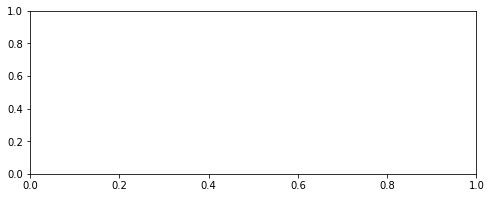

In [6]:
fig = plt.figure(figsize=(8.0, 3.0))
ax = fig.add_subplot(111)
graphics.plot_sequence_logo(ax, alignment)
ax.set_xticks([5,10,15,20])
ax.set_xlabel("Residue position")
ax.set_ylabel("Bits")
# Only show left and bottom spine
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.tight_layout()
# sphinx_gallery_thumbnail_number = 2

plt.show()